## Модель классификации риса на основе ResNet50  

В этом проекте для решения задачи классификации пяти сортов риса с помощью миграционного обучения была использована предварительно обученная модель ResNet50.

[Rice Images Dataset](https://www.kaggle.com/datasets/mbsoroush/rice-images-dataset)

In [ ]:
import splitfolders

data_path = "../rice/rice-dataset"
output_path = "../rice/rice-dataset-split"

# 划分为 70% 训练集，15% 验证集，15% 测试集
#  Разделены на 70% обучающего набора, 15% валидационного набора, 15% тестового набора
splitfolders.ratio(data_path, output=output_path, seed=42, ratio=(0.7, 0.15, 0.15))

print("数据集划分完成，存储在:", output_path)


GPU switch command ( TCC ): nvidia-smi -dm 1  
GPU switch command ( WDDM ): nvidia-smi -dm 0  
output: All done

In [12]:
import torch

print("PyTorch 版本:", torch.__version__)
print("CUDA 是否可用:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("设备名称:", torch.cuda.get_device_name(0))
else:
    print("未检测到 CUDA")
print("CUDA 版本:", torch.version.cuda)
print("cuDNN 版本:", torch.backends.cudnn.version())


PyTorch 版本: 2.5.1+cu118
CUDA 是否可用: True
设备名称: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA 版本: 11.8
cuDNN 版本: 90100


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


数据加载与预处理  
Загрузка и предварительная обработка данных

In [13]:
data_dir = "../rice/rice-dataset-split"

# 数据增强与预处理
# Расширение и предварительная обработка данных
transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),  # 调整大小 изменить размер
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.RandomRotation(15),  # 随机旋转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 数据加载器
# Загрузчик данных
batch_size = 32

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform["train"])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform["val"])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform["val"])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Category mapping
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


加载ResNet50，并替换分类层  
Загрузите ResNet50 и замените слой классификации

In [ ]:
# 加载预训练模型 ResNet50
# Загрузка предварительно обученной модели ResNet50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))  # Replace with rice classification

model = model.to(device)


C:\Users\yty43\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yty43\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


定义损失函数和优化器  
Определение функции потерь и оптимизатора

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_model_wts = None
    best_acc = 0.0
    history = {"train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # training 
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        train_acc = correct.double() / total
        history["train_acc"].append(train_acc.item())

        # validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

        val_acc = correct.double() / total
        history["val_acc"].append(val_acc.item())

        print(f"Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")

        # 保存最优模型
        # Сохранение оптимальной модели
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    # 加载最优权重
    # Загрузка оптимальных весов
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history


训练和保存模型  
Модели обучения и экономии

In [ ]:
num_epochs = 10
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

torch.save(model.state_dict(), "resnet50_rice_classification.pth")

Epoch 1/10
Train Accuracy: 0.9741 | Validation Accuracy: 0.8660
Epoch 2/10
Train Accuracy: 0.9898 | Validation Accuracy: 0.9943
Epoch 3/10
Train Accuracy: 0.9938 | Validation Accuracy: 0.9941
Epoch 4/10
Train Accuracy: 0.9946 | Validation Accuracy: 0.9915
Epoch 5/10
Train Accuracy: 0.9954 | Validation Accuracy: 0.9961
Epoch 6/10
Train Accuracy: 0.9946 | Validation Accuracy: 0.9984
Epoch 7/10
Train Accuracy: 0.9970 | Validation Accuracy: 0.9980
Epoch 8/10
Train Accuracy: 0.9955 | Validation Accuracy: 0.9790
Epoch 9/10
Train Accuracy: 0.9971 | Validation Accuracy: 0.9992
Epoch 10/10
Train Accuracy: 0.9972 | Validation Accuracy: 0.9979


测试模型  
тестовая модель

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"Test Accuracy: {correct.double() / total:.4f}")
    return y_true, y_pred

y_true, y_pred = test_model(model, test_loader)


Test Accuracy: 0.9977


混淆矩阵与分类报告  
Матрица смешения и отчет о классификации

              precision    recall  f1-score   support

     Arborio       0.99      1.00      1.00      2250
     Basmati       1.00      1.00      1.00      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       1.00      1.00      1.00      2250
   Karacadag       1.00      0.99      1.00      2250

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250



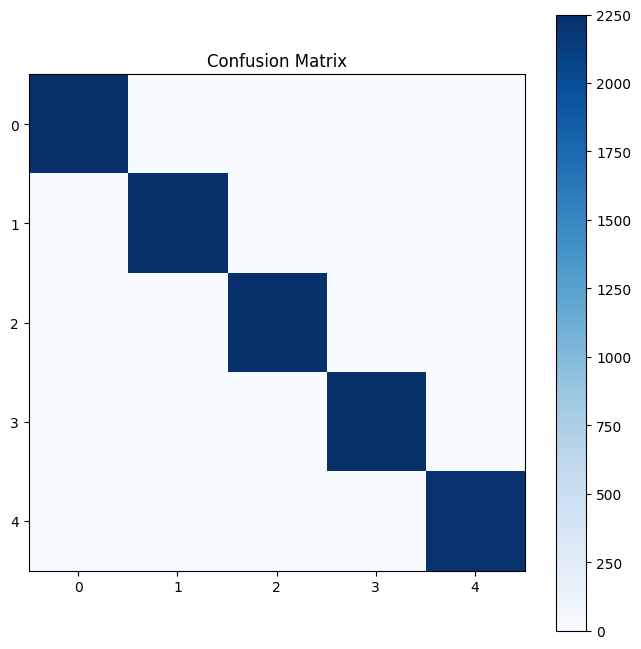

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.show()
